<font size="+3">Estimation de posture dans une image — Partie 1</font>

_À partir partir d'un TP proposé par Axel Carlier._

---

Pour ce TP ainsi que le suivant, nous allons traiter le problème de la détection du "squelette" d'un humain dans une image, tel qu'illustré dans la figure ci-dessous.

![Texte alternatif…](https://drive.google.com/uc?id=1HpyLwzwkFdyQ6APoGZQJL7f837JCHNkh)

Nous allons pour ce faire utiliser le [Leeds Sport Pose Dataset](https://sam.johnson.io/research/lspet.html) qui introduit 10000 images présentant des sportifs dans diverses situations, augmentées d'une annotation manuelle du squelette.

À chaque image est associée une matrice de taille 3$\times$14, correspondant aux coordonnées dans l'image des 14 joints (articulations) du squelette de la personne décrite dans l'image. La 3ème dimension désigne la visibilité du joint (1 s'il est visible, 0 s'il est occulté)

Ces joints sont, dans l'ordre :
*   Cheville droite
*   Genou droit
*   Hanche droite
*   Hanche gauche
*   Genou gauche
*   Cheville gauche
*   Poignet droit
*   Coude droit
*   Épaule droite
*   Épaule gauche
*   Coude gauche
*   Poignet gauche
*   Cou
*   Sommet du crâne

Pour un rappel des notions vues en cours sur ce sujet, vous pouvez regarder la vidéo ci-dessous :


In [1]:
from IPython.display import IFrame
IFrame("https://video.polymny.studio/?v=84ace9c1-f460-4375-9b33-917c3ff82c83/", width=640, height=360)

# Méthodologie 

Pour résoudre ce problème, nous allons suivre une méthodologie similaire à celle présentée dans le 2e cours, et rappelée sur la figure suivante : 

![Méthodologie de développement d'un algorithme d'apprentissage profond](https://drive.google.com/uc?id=195pkcjca4r_g86KDt2LCe0QdQsMC6iba)

Ainsi nous allons commencer par une modélisation simple du problème, construire un modèle et l'améliorer pas à pas et évaluer sa performance.
Dans un second temps, nous modifierons la modélisation du problème, et donc l'architecture utilisée, afin d'améliorer les résultats.

Pour chacune de ces deux étapes, je vous suggère de suivre la démarche suivante : 

- Simplifier le problème en traitant 10 imagettes (par exemple de dimension $64 \times 64$) et construire un réseau qui surapprend parfaitement (qui diminue la perte jusqu'à quasiment 0)
- Ajouter des images (~1000) et recalibrer le réseau pour à nouveau, obtenir un sur-apprentissage
- Commencer à corriger le sur-apprentissage en ajoutant de la régularisation
- Et enfin, utiliser l'ensemble de la base de données pour diminuer le sur-apprentissage au maximum

# Régression de la position des joints

Dans un premier temps, et comme vu en cours, nous allons nous inspirer de l'algorithme DeepPose (**[[Toshev et al.]](https://arxiv.org/abs/1312.4659)** _DeepPose : Human Pose Estimation via Deep Neural Networks_) et formuler le problème comme une régression de la position $(x,y)$ des joints dans l'espace de l'image.

Commencez par télécharger la base de données sur Github




In [2]:
!git clone https://github.com/axelcarlier/lsp.git

fatal: destination path 'lsp' already exists and is not an empty directory.


Le bloc suivant contient une fonction qui permet de charger les images de la base de données dans les variables x et y. Par défaut les images sont redimensionnées en taille 128$\times$128 et la base de données contient 1000 images. Pour commencer et vous permettre de travailler plus efficacement, **je vous suggère très fortement de diminuer la dimension des images** (par exemple 64$\times$64) **et de ne travailler que sur un ensemble réduit d'images** (par exemple, 10). 


N'oubliez pas également de diviser les données en images de test et/ou de validation pour obtenir des informations sur le sur-apprentissage éventuel. 


In [3]:
import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

In [32]:
# Cette fonction permettra plus tard de charger plus ou moins d'images (en modifiant le paramètre num_images)
# et de modifier la dimension d'entrée
def load_data(image_size=128, num_images=1000):

    path = "./lsp/images/"
    dirs = sorted(os.listdir(path))

    x = np.zeros((min(num_images,len(dirs)),image_size,image_size,3))
    y = np.zeros((min(num_images,len(dirs)), 3, 14))

    #Chargement des joints    
    mat_contents = loadmat('./lsp/joints.mat')
    joints = mat_contents['joints']

    # Chargement des images, qui sont rangées dans lsp/images
    for i in range(min(num_images,len(dirs))):
        item = dirs[i]
        if os.path.isfile(path+item):
            img = Image.open(path+item)
            # Redimensionnement et sauvegarde des joints
            y[i, 0] = joints[:,0,i]*image_size/img.size[0]
            y[i, 1] = joints[:,1,i]*image_size/img.size[1]
            y[i, 2] = joints[:,2,i]
            # Redimensionnement et sauvegarde des images        
            img = img.resize((image_size,image_size))
            x[i] = np.asarray(img)


    return x, y

# Chargement de seulement 10 images, de taille 64x64
x, y = load_data(image_size=64, num_images=10)           
x.shape, y.shape

((10, 64, 64, 3), (10, 3, 14))

In [33]:
labels= {0: 'Cheville droite',
         1: 'Genou droit',
         2: 'Hanche droite',
         3: 'Hanche gauche',
         4: 'Genou gauche',
         5: 'Cheville gauche',
         6: 'Poignet droit',
         7: 'Coude droit',
         8: 'Épaule droite',
         9: 'Épaule gauche',
         10: 'Coude gauche',
         11: 'Poignet gauche',
         12: 'Cou',
         13: 'Sommet du crâne'}

La fonction suivante vous permet de visualiser les données. Vous vous rendrez compte que certaines données sont manquantes ! En effet quand des joints sont occultés dans les images, des valeurs de position aberrantes (négatives) sont indiquées. Dans ce cas, nous n'afficherons pas les articulations.

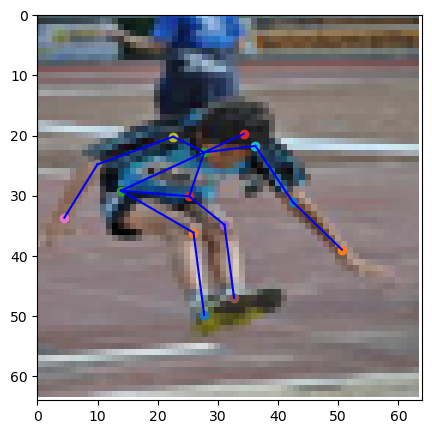

In [34]:
import matplotlib.pyplot as plt

# Fonction d'affichage d'une image et de son label associé
def print_data(x,y,i):

    if y.shape[1] < 3:
        y_new = np.ones((y.shape[0], 3, y.shape[2]))
        y_new[:,0:2,:] = y
        y = y_new

    plt.figure(figsize=(5, 5))
    plt.imshow(x[i]/255)
    for j in range(0,14):
        if y[i, 2, j] == 1:
            plt.scatter(y[i,0,j],y[i,1,j],label=labels.get(j))

    # Jambe droite      
    if (y[i, 2, 0] + y[i, 2, 1] == 2):
        plt.plot(y[i,0,0:2],y[i,1,0:2],'b')
    # Cuisse droite      
    if (y[i, 2, 1] + y[i, 2, 2] == 2):
        plt.plot(y[i,0,1:3],y[i,1,1:3],'b')
    # Bassin     
    if (y[i, 2, 2] + y[i, 2, 3] == 2):
        plt.plot(y[i,0,2:4],y[i,1,2:4],'b')
    # Cuisse gauche      
    if (y[i, 2, 3] + y[i, 2, 4] == 2):
        plt.plot(y[i,0,3:5],y[i,1,3:5],'b')
    # Jambe gauche      
    if (y[i, 2, 4] + y[i, 2, 5] == 2):
        plt.plot(y[i,0,4:6],y[i,1,4:6],'b')
    # Avant-bras droit      
    if (y[i, 2, 6] + y[i, 2, 7] == 2):
        plt.plot(y[i,0,6:8],y[i,1,6:8],'b')
    # Bras droit      
    if (y[i, 2, 7] + y[i, 2, 8] == 2):
        plt.plot(y[i,0,7:9],y[i,1,7:9],'b')
    # Bras gauche     
    if (y[i, 2, 9] + y[i, 2, 10] == 2):
        plt.plot(y[i,0,9:11],y[i,1,9:11],'b')
    # Avant-bras gauche      
    if (y[i, 2, 10] + y[i, 2, 11] == 2):
        plt.plot(y[i,0,10:12],y[i,1,10:12],'b') 
    # Buste droit
    x1=[y[i,0,2],y[i,0,12]]
    y1=[y[i,1,2],y[i,1,12]]
    if (y[i, 2, 2] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Buste gauche
    x1=[y[i,0,3],y[i,0,12]]
    y1=[y[i,1,3],y[i,1,12]]
    if (y[i, 2, 3] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Omoplate droite
    x1=[y[i,0,8],y[i,0,12]]
    y1=[y[i,1,8],y[i,1,12]]
    if (y[i, 2, 8] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Omoplate gauche
    x1=[y[i,0,9],y[i,0,12]]
    y1=[y[i,1,9],y[i,1,12]]
    if (y[i, 2, 9] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Tete     
    if (y[i, 2, 12] + y[i, 2, 13] == 2):
        plt.plot(y[i,0,12:14],y[i,1,12:14],'b')

    plt.axis([0, x.shape[1], x.shape[2], 0])
    plt.show()
    #plt.legend()

# Affichage aléatoire d'une image
print_data(x,y,np.random.randint(x.shape[0]-1))

Si nous formulons ce problème comme une régression, nous allons utiliser pour évaluer nos réseaux de neurones l'erreur quadratique moyenne (fonction *MSE*). Cette fonction sera parfaite comme fonction de perte, mais elle ne permet pas d'appréhender les résultats de manière satisfaisante.

Une métrique commune en estimation de posture est le **PCK0.5**, pour *Percentage of Correct Keypoints*. *0.5* correspond à un seuil en-deça duquel on considère qu'un joint est correctement estimé. Cette question du seuil est particulièrement sensible car il faut utiliser une valeur qui soit valable pour n'importe quelle image. La personne considérée peut apparaître plus ou moins largement sur l'image, de face ou de profil, ce qui fait qu'une erreur de prédiction sur un joint peut avoir une importance très grande ou très faible selon les cas.

Pour résoudre cette ambiguïté, on considère dans la métrique du **PCK0.5** que la référence est la taille de la tête, définie par la distance entre le joint du cou et le joint de la tête sur la vérité terrain. Un joint prédit par le réseau sera considéré correct s'il est situé à une distance inférieure à la moitié (*0.5*) de la taille de la tête par rapport au joint réel. (**[[Andriluka et al.]](https://openaccess.thecvf.com/content_cvpr_2014/html/Andriluka_2D_Human_Pose_2014_CVPR_paper.html)** _2D Human Pose Estimation: New Benchmark and State of the Art Analysis_)

In [7]:
import numpy.matlib 

# Calcul du "Percentage of Correct Keypoint" avec seuil alpha :
# On compte corrects les joints pour lesquels la distance entre valeurs réelle et prédite 
# est inférieure à alpha fois la dimension de la tête (c'est un peu arbitraire...)
# On ne comptera pas les joints invisibles.
# y_true est de dimension Nx3x14 et y_pred Nx2x14 (le réseau ne prédit pas la visibilité)

def compute_PCK_alpha(y_true, y_pred, alpha=0.5):
    # Calcul des seuils ; la taille de la tête est la distance entre joints 12 et 13
    head_sizes = np.sqrt(np.square(y_true[:,0,13]-y_true[:,0,12])+np.square(y_true[:,1,13]-y_true[:,1,12]))
    thresholds = alpha*head_sizes
    thresholds = np.matlib.repmat(np.expand_dims(thresholds, 1), 1, 14)

    # Calcul des distances inter-joints
    joints_distances = np.sqrt(np.square(y_true[:,0,:]-y_pred[:,0,:]) + np.square(y_true[:,1,:]-y_pred[:,1,:]))

    # Visibilité des joints de la vérité terrain
    visibility = y_true[:,2,:]
    
    total_joints = np.count_nonzero(visibility==1)
    correctly_predicted_joints = np.count_nonzero(np.logical_and(joints_distances<thresholds, visibility == 1))
    
    return correctly_predicted_joints/total_joints

Comme dit précédemment, on va utiliser l'erreur quadratique moyenne (*[MSE](https://en.wikipedia.org/wiki/Mean_squared_error)*) comme fonction de coût pour entraîner notre réseau de neurones, et on peut également utiliser l'erreur absolue moyenne (*[MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)*) pour obtenir une estimation plus fine des performances de notre réseau pendant l'entraînement (on obtient une erreur moyenne en pixels, ce qui est plus simple à interpréter).

Il y a cependant une subtilité importante évoquée un peu plus haut : certains joints sont invisibles, et ont des coordonnées négatives (pour, il faut l'avouer, une raison un peu inexplicable). Il est important de ne pas affecter l'apprentissage en faisant prédire ces valeurs négatives, insensées, au réseau. 

On doit donc implanter nous-même notre propre fonction de coût, qui ne va pas prendre en compte les joints invisibles. Pour cela, il faut savoir que la vérité-terrain contient en fait 3 valeurs pour chaque joint : les 2 premières sont ses coordonnées sur l'image, la 3e représente la visibilité du joint (1 s'il est visible, 0 sinon).

La fonction *custom_mse*, définie juste en-dessous, réalise cette opération. Prenez le temps de comprendre ce qu'il s'y passe. 

**Remarque importante** : Ce code fait appel à des fonctions particulières du Backend de `Keras`, dont vous trouverez les détails sur [cette page](https://keras.rstudio.com/articles/backend.html). Ces fonctions doivent traiter des tenseurs, de type *Tensor* (et pas des tableaux numpy), car elles seront appelées pendant l'entraînement sur des variables internes à `Tensorflow`. Les fonctions utilisables sont également limitées car il faut pouvoir dériver la fonction *custom_mse* pour la rétropropagation des gradients.

In [8]:
import keras.backend as K

# y_true : vérité terrain de dimension B x 3 x 14
# y_pred : une prédiction de dimension B x 2 x 14 (on ne prédit pas la visibilité)
# B est le nombre d'images considérées (par exemple, pourra être la taille d'un mini-batch)

def custom_mse(y_true, y_pred):
    # Changement de dimension : Bx3x14 -> Bx14x3
    y_true = K.permute_dimensions(y_true, (0, 2, 1))
    # Changement de dimension : Bx14x3 -> (B*14)x3
    y_true = K.reshape(y_true, shape=(-1, 3))
  
    # Changement de dimension : Bx2x14 -> Bx14x2
    y_pred = K.permute_dimensions(y_pred, (0, 2, 1))
    # Changement de dimension : Bx14x2 -> (B*14)x2
    y_pred = K.reshape(y_pred, shape=(-1, 2))
    
    # Détermination de l'indices des joints visibles
    visible = K.greater_equal(y_true[:, 2], 1)  
    indices = K.arange(0, K.shape(y_true)[0])
    indices_visible = indices[visible]
    
    # Sélection des vérité-terrains et prédictions des joints visibles
    y_true_visible = K.gather(y_true[:,0:2], indices_visible)
    y_pred_visible = K.gather(y_pred, indices_visible)
    
    # Calcul de la MSE
    return K.mean(K.square(y_pred_visible[:,0] - y_true_visible[:,0]) + K.square(y_pred_visible[:,1] - y_true_visible[:,1]))

Si vous avez bien compris le code de *custom_mse*, vous devriez pouvoir sans trop de problèmes écrire le code pour la fonction *custom_mae* ci-dessous :

In [9]:
# y_true : vérité terrain de dimension B x 3 x 14
# y_pred : une prédiction de dimension B x 2 x 14 (on ne prédit pas la visibilité)
# B est le nombre d'images considérées (par exemple, pourra être la taille d'un mini-batch)

def custom_mae(y_true, y_pred):
    y_true = K.permute_dimensions(y_true, (0, 2, 1))
    y_true = K.reshape(y_true, shape=(-1, 3))
  
    y_pred = K.permute_dimensions(y_pred, (0, 2, 1))
    y_pred = K.reshape(y_pred, shape=(-1, 2))
    
    visible = K.greater_equal(y_true[:, 2], 1)  
    indices = K.arange(0, K.shape(y_true)[0])
    indices_visible = indices[visible]
    
    y_true_visible = K.gather(y_true[:,0:2], indices_visible)
    y_pred_visible = K.gather(y_pred, indices_visible)
    
    return K.mean(K.abs(y_pred_visible[:,0] - y_true_visible[:,0]) + K.abs(y_pred_visible[:,1] - y_true_visible[:,1]))

Comme d'habitude, on peut monitorer l'entraînement grâce à la fonction suivante (adaptée à nos fonctions *custom_mse* et *custom_mae* définies juste avant) : 

In [10]:
def plot_training_analysis(history):
    mae = history.history['custom_mae']
    val_mae = history.history['val_custom_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.plot(epochs, mae, 'b', linestyle="--",label='Training MAE')
    plt.plot(epochs, val_mae, 'g', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# A vous de jouer :

Pour tenter de résoudre le problème, vous pouvez suivre les étapes suivantes : 

- Simplifier le problème en traitant 10 imagettes (par exemple de dimension $64 \times 64$) et construire un réseau qui surapprend parfaitement (qui diminue la perte jusqu'à quasiment 0)
- Ajouter des images (~1000) et éventuellement recalibrer votre réseau pour à nouveau, obtenir un sur-apprentissage
- Commencer à corriger le sur-apprentissage en ajoutant de la régularisation (notamment sur les couches denses)
- Et enfin, utiliser l'ensemble de la base de données pour diminuer le sur-apprentissage au maximum


# Correction

In [11]:
import keras
from keras.layers import *
from keras import models
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers

## Surapprentissage sur 10 images de taille 64x64

L'utilisation de la fonction `train_test_split` permet, par effet de bord, de s'assurer que l'on travaille bien avec des tenseurs. Sinon, il faut s'assurer _a minima_ de convertir nos $\texttt{numpy.array}$ en $\texttt{keras.tensor}$ pour les donner en entrée du réseau, sous peine de voir un message d'erreur s'afficher.

In [12]:
# Chargement des données : 10 images d'apprentissage, 2 de validation, 2 de test    
x, y = load_data(image_size=64, num_images=14)       
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=4/14, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(10, 64, 64, 3) (2, 64, 64, 3) (2, 64, 64, 3)
(10, 3, 14) (2, 3, 14) (2, 3, 14)


On cherche à faire de la régression sur des images. En suivant la méthodologie _"commencer simple et complexifier"_, on va commencer par proposer le réseau le plus simple qu'il soit pour cela : à savoir un réseau de type [$\texttt{LeNet}$](https://en.wikipedia.org/wiki/LeNet), succession de couches de convolution et de pooling ($\texttt{DeepPose}$ est basé sur [$\texttt{AlexNet}$](https://en.wikipedia.org/wiki/AlexNet), c'est donc un choix simplificateur). 

Il nous reste donc à déterminer un nombre de couches Convolution+Pooling, la taille des noyaux de convolution, le nombre de filtres pour chaque couche de convolution, la taille de pooling, _etc._ Lorsque l'on ne sait pas comment partir, on peut suivre l'idée de $\texttt{VGG16}$ et (i) choisir un taille de noyau constante, (ii) un nombre de filtres croissant, (iii) une diminution de la taille des images le long du réseau.

### Un premier modèle (plus performant) $\implies$ On conserve ce réseau

**Attention !** : Il faut bien penser à redimensionner $\hat{y}$ en sortie du réseau pour qu'il soit de la même dimension que $y_{train}$.

In [13]:
# Définition d'un modèle simple, type "LeNet"

model = models.Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=(64,64,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(28, activation='linear'))
model.add(Reshape((2,14)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 96)         0

2023-03-15 06:22:14.507602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# On utilise Adam, et on va minimiser la MSE
# On affiche également la métrique MAE, qui nous permettra d'avoir une valeur plus interprétable
opt = optimizers.Adam(learning_rate=3e-4) 

model.compile(loss=custom_mse,
              optimizer=opt,
              metrics=custom_mae)

history = model.fit(x_train, y_train,
          epochs=200,
          validation_data = (x_val, y_val), 
          batch_size=10)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 2011.5934 - custom_mae: 53.8307 - val_loss: 1026.3378 - val_custom_mae: 39.1119
Epoch 2/200
1/1 [==============================] - 0s 94ms/step - loss: 846.4910 - custom_mae: 34.1704 - val_loss: 452.7234 - val_custom_mae: 23.5449
Epoch 3/200
1/1 [==============================] - 0s 85ms/step - loss: 385.5825 - custom_mae: 21.7790 - val_loss: 247.1079 - val_custom_mae: 19.2596
Epoch 4/200
1/1 [==============================] - 0s 87ms/step - loss: 346.4416 - custom_mae: 20.5434 - val_loss: 204.4197 - val_custom_mae: 17.6044
Epoch 5/200
1/1 [==============================] - 0s 91ms/step - loss: 338.4838 - custom_mae: 20.7430 - val_loss: 199.7495 - val_custom_mae: 16.6106
Epoch 6/200
1/1 [==============================] - 0s 85ms/step - loss: 252.8875 - custom_mae: 17.8561 - val_loss: 257.1945 - val_custom_mae: 18.1848
Epoch 7/200
1/1 [==============================] - 0s 82ms/step - loss: 205.9444 - custom_mae: 16.16

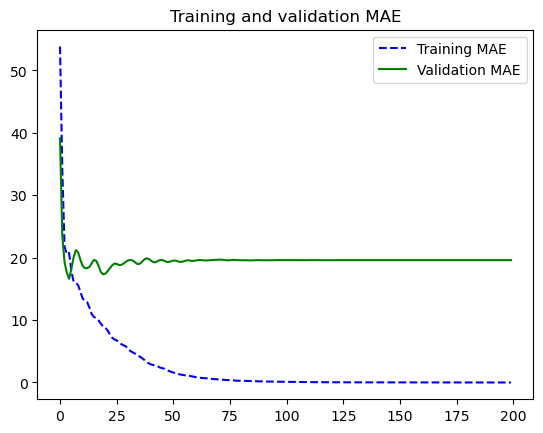

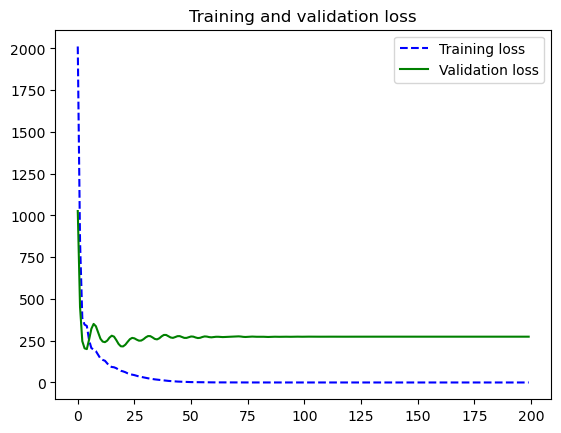

---
Training PCK@0.5 = 1.0
Validation PCK@0.5 = 0.0
Test PCK@0.5 = 0.0
---


In [15]:
plot_training_analysis(history)

# Calcul du PCK
print('---')   
y_pred = model.predict(x_train)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_pred = model.predict(x_val)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_pred = model.predict(x_test)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))
print('---')

**Observation**: Le réseau apprend, ou plutôt sur-apprend, parfaitement ! La MAE et la loss d'apprentissage sont nulles, et le PCK est à 1. En revanche les résultats sur les ensemble de validation et de test sont très mauvais. 

### Un exemple de modèle (un peu) moins performant

In [16]:
# Définition d'un autre modèle simple, type "LeNet" (moins performant)

model = models.Sequential()

model.add(Conv2D(32, (5,5), input_shape=(64,64,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(96,(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(28, activation='linear'))
model.add(Reshape((2,14)))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 96)          153696    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 96)        

In [17]:
model.compile(loss=custom_mse,
              optimizer=opt,
              metrics=custom_mae)

history = model.fit(x_train, y_train,
          epochs=200,
          validation_data = (x_val, y_val), 
          batch_size=10)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 1644.2250 - custom_mae: 52.0951 - val_loss: 1345.3539 - val_custom_mae: 46.7127
Epoch 2/200
1/1 [==============================] - 0s 70ms/step - loss: 1171.9983 - custom_mae: 42.0048 - val_loss: 664.7546 - val_custom_mae: 28.6731
Epoch 3/200
1/1 [==============================] - 0s 71ms/step - loss: 684.7760 - custom_mae: 29.9087 - val_loss: 518.2698 - val_custom_mae: 28.5809
Epoch 4/200
1/1 [==============================] - 0s 72ms/step - loss: 748.1420 - custom_mae: 30.9035 - val_loss: 279.5640 - val_custom_mae: 19.6117
Epoch 5/200
1/1 [==============================] - 0s 76ms/step - loss: 347.6914 - custom_mae: 21.0185 - val_loss: 409.3779 - val_custom_mae: 23.0760
Epoch 6/200
1/1 [==============================] - 0s 80ms/step - loss: 363.7161 - custom_mae: 21.6739 - val_loss: 436.1872 - val_custom_mae: 22.8384
Epoch 7/200
1/1 [==============================] - 0s 75ms/step - loss: 347.4741 - custom_mae: 20.9

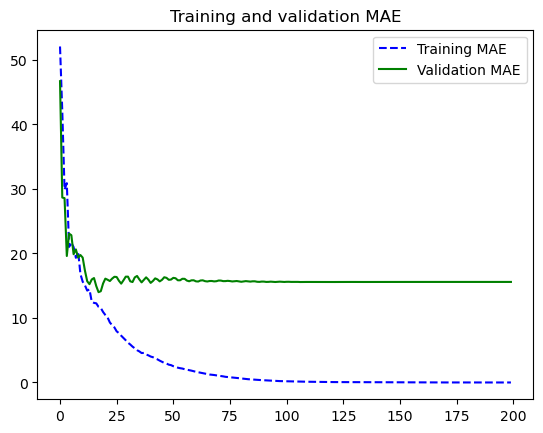

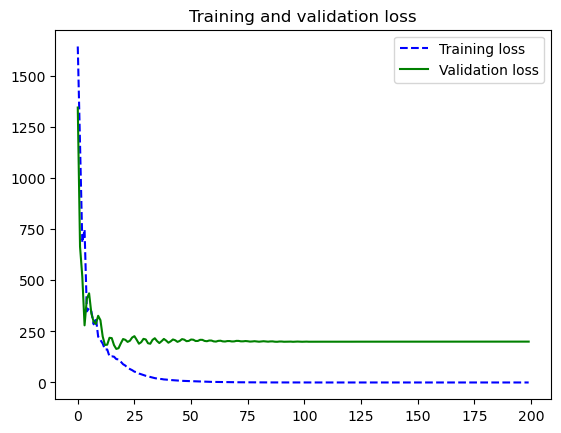

---
Training PCK@0.5 = 1.0
Validation PCK@0.5 = 0.041666666666666664
Test PCK@0.5 = 0.0
---


In [18]:
plot_training_analysis(history)

# Calcul du PCK
print('---')   
y_pred = model.predict(x_train)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_pred = model.predict(x_val)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_pred = model.predict(x_test)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))
print('---')

**Observation**: Ce second réseau, sans $\texttt{padding}$, sur-apprend moins bien que le premier. On choisit de conserver le premier.

In [19]:
def simple_CNN(image_size=64):
    # Définition du modèle simple, de type "LeNet" (§ 4.1.1)
    
    model = models.Sequential()
    
    model.add(Conv2D(32,(3,3), padding='same', input_shape=(image_size,image_size,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(96,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(28, activation='linear'))
    model.add(Reshape((2,14)))

    return model

In [20]:
model = simple_CNN(image_size=64)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 96)        55392     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 96)        

## Test sur 1000 images d'apprentissage

In [21]:
# Chargement des données : 1000 images d'apprentissage, 100 de validation, 100 de test    
x, y = load_data(image_size=64, num_images=1200)       
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/6, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

print(x_train.shape, x_val.shape, x_test.shape)


# Définition du modèle
model = simple_CNN(image_size=64)
opt = optimizers.Adam(learning_rate=3e-4) 


model.compile(loss=custom_mse,
              optimizer=opt,
              metrics=custom_mae)

history = model.fit(x_train, y_train,
          epochs=50,
          validation_data = (x_val, y_val), 
          batch_size=10)

(1000, 64, 64, 3) (100, 64, 64, 3) (100, 64, 64, 3)
Epoch 1/50
100/100 [==============================] - 6s 55ms/step - loss: 350.2504 - custom_mae: 20.7678 - val_loss: 298.1998 - val_custom_mae: 19.3413
Epoch 2/50
100/100 [==============================] - 5s 52ms/step - loss: 289.2495 - custom_mae: 19.1799 - val_loss: 280.2106 - val_custom_mae: 18.9181
Epoch 3/50
100/100 [==============================] - 5s 50ms/step - loss: 265.5743 - custom_mae: 18.3126 - val_loss: 266.8838 - val_custom_mae: 18.4071
Epoch 4/50
100/100 [==============================] - 5s 52ms/step - loss: 244.9521 - custom_mae: 17.4956 - val_loss: 260.1928 - val_custom_mae: 17.8308
Epoch 5/50
100/100 [==============================] - 5s 49ms/step - loss: 227.2077 - custom_mae: 16.7942 - val_loss: 262.8536 - val_custom_mae: 18.1047
Epoch 6/50
100/100 [==============================] - 5s 51ms/step - loss: 205.4237 - custom_mae: 15.9965 - val_loss: 295.6126 - val_custom_mae: 19.0629
Epoch 7/50
100/100 [==========

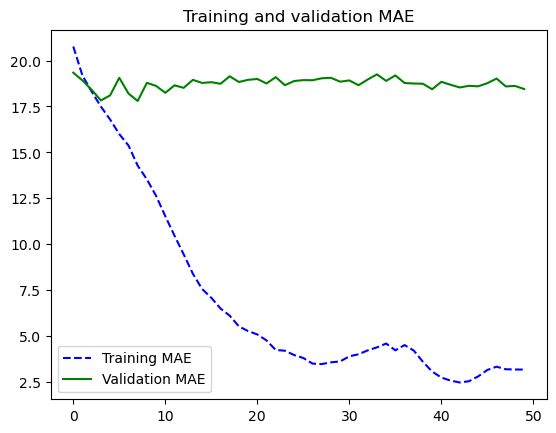

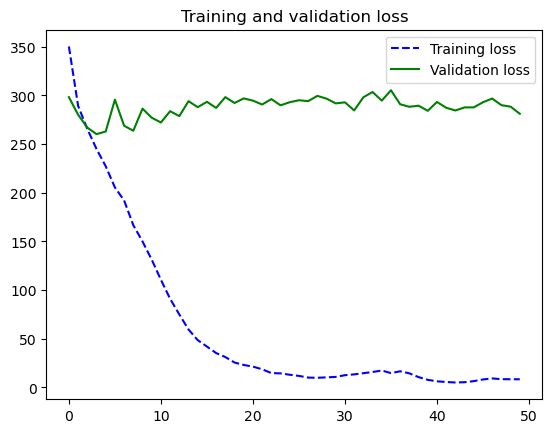

---
Training PCK@0.5 = 0.6894106138420152
Validation PCK@0.5 = 0.19853539462978032
Test PCK@0.5 = 0.15177865612648223
---


In [22]:
plot_training_analysis(history)

# Calcul du PCK
print('---')   
y_pred = model.predict(x_train)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_pred = model.predict(x_val)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_pred = model.predict(x_test)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))
print('---')

**Observations :** On a toujours un fort sur-apprentissage, mais en plus maintenant on sous-apprend également. La MAE stagne aux alentours de 3 sur l'ensemble d'aprentissage, et le PCK à 0.5 ce qui est assez mauvais ! _**Le problème vient du fait que l'on a pas normalisé les entrées !!!**_

## Test sur 1000 images d'apprentissage, **<span style="color:purple">avec normalisation</span>** !

### Normalisation des entrées

In [23]:
# Chargement des données : 1000 images d'apprentissage, 100 de validation, 100 de test ET NORMALISATION
x, y = load_data(image_size=64, num_images=1200)  
x = x/255
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/6, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

print(x_train.shape, x_val.shape, x_test.shape)

# Définition du modèle
model = simple_CNN(image_size=64)
opt = optimizers.Adam(learning_rate=3e-4) 

model.compile(loss=custom_mse,
              optimizer=opt,
              metrics=custom_mae)

history = model.fit(x_train, y_train,
          epochs=150,
          validation_data = (x_val, y_val), 
          batch_size=10)

(1000, 64, 64, 3) (100, 64, 64, 3) (100, 64, 64, 3)
Epoch 1/150
100/100 [==============================] - 6s 52ms/step - loss: 562.2488 - custom_mae: 26.0910 - val_loss: 291.6764 - val_custom_mae: 19.1061
Epoch 2/150
100/100 [==============================] - 5s 50ms/step - loss: 282.0436 - custom_mae: 18.9443 - val_loss: 325.3356 - val_custom_mae: 20.0447
Epoch 3/150
100/100 [==============================] - 5s 49ms/step - loss: 284.2171 - custom_mae: 19.0566 - val_loss: 270.4899 - val_custom_mae: 18.5960
Epoch 4/150
100/100 [==============================] - 5s 49ms/step - loss: 262.5259 - custom_mae: 18.3046 - val_loss: 259.9895 - val_custom_mae: 18.2033
Epoch 5/150
100/100 [==============================] - 6s 60ms/step - loss: 261.2112 - custom_mae: 18.3356 - val_loss: 267.0400 - val_custom_mae: 18.1469
Epoch 6/150
100/100 [==============================] - 6s 55ms/step - loss: 253.5856 - custom_mae: 18.0042 - val_loss: 268.7945 - val_custom_mae: 18.2106
Epoch 7/150
100/100 [===

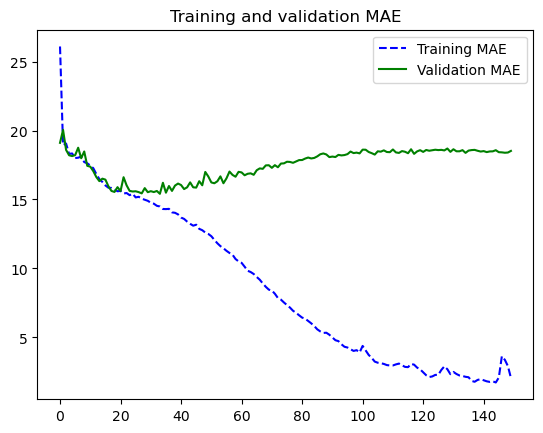

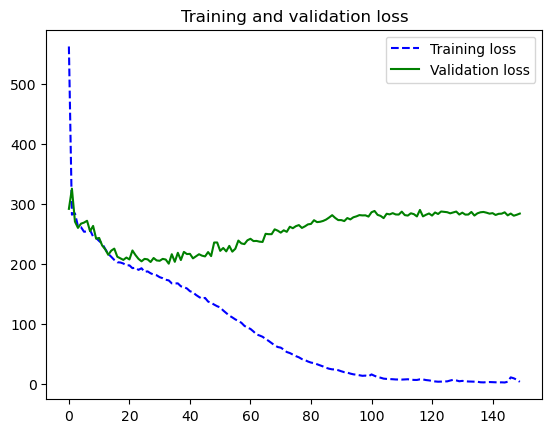

---
Training PCK@0.5 = 0.8654927855221326
Validation PCK@0.5 = 0.1903986981285598
Test PCK@0.5 = 0.15889328063241107
---


In [24]:
plot_training_analysis(history)

# Calcul du PCK
print('---')   
y_pred = model.predict(x_train)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_pred = model.predict(x_val)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_pred = model.predict(x_test)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))
print('---')

**Observations** : Le sous-apprentissage s'est beaucoup amélioré mais n'est toujours pas parfait. En revanche le sur-apprentissage a empiré !
Pour limiter encore le sous-apprentissage on peut essayer d'augmenter la capacité de notre réseau.

### Augmentation de la capacité du réseau

In [25]:
# Chargement des données : 1000 images d'apprentissage, 100 de validation, 100 de test    
x, y = load_data(image_size=64, num_images=1200)  
x = x/255
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/6, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

print(x_train.shape, x_val.shape, x_test.shape)


# Définition d'un modèle simple, type "LeNet" plus complexe que "simple_CNN"
model = models.Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(64,64,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(384,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(28,activation='linear'))
model.add(Reshape((2,14)))


# On utilise Adam, et on va minimiser la MSE
# On affiche également la métrique MAE, qui nous permettra d'avoir une valeur plus interprétable
opt = optimizers.Adam(learning_rate=3e-4) 


model.compile(loss=custom_mse,
              optimizer=opt,
              metrics=custom_mae)

history = model.fit(x_train, y_train,
          epochs=150,
          validation_data = (x_val, y_val), 
          batch_size=10)

(1000, 64, 64, 3) (100, 64, 64, 3) (100, 64, 64, 3)
Epoch 1/150
100/100 [==============================] - 12s 115ms/step - loss: 454.6047 - custom_mae: 23.2501 - val_loss: 317.8902 - val_custom_mae: 20.2478
Epoch 2/150
100/100 [==============================] - 11s 113ms/step - loss: 284.5663 - custom_mae: 19.0356 - val_loss: 272.2325 - val_custom_mae: 18.5792
Epoch 3/150
100/100 [==============================] - 12s 118ms/step - loss: 267.0270 - custom_mae: 18.4612 - val_loss: 275.4810 - val_custom_mae: 18.5693
Epoch 4/150
100/100 [==============================] - 12s 116ms/step - loss: 264.3038 - custom_mae: 18.3979 - val_loss: 256.7198 - val_custom_mae: 17.9790
Epoch 5/150
100/100 [==============================] - 11s 113ms/step - loss: 257.9691 - custom_mae: 18.1611 - val_loss: 259.5844 - val_custom_mae: 18.0019
Epoch 6/150
100/100 [==============================] - 11s 113ms/step - loss: 256.0809 - custom_mae: 18.1032 - val_loss: 253.8741 - val_custom_mae: 17.6988
Epoch 7/150


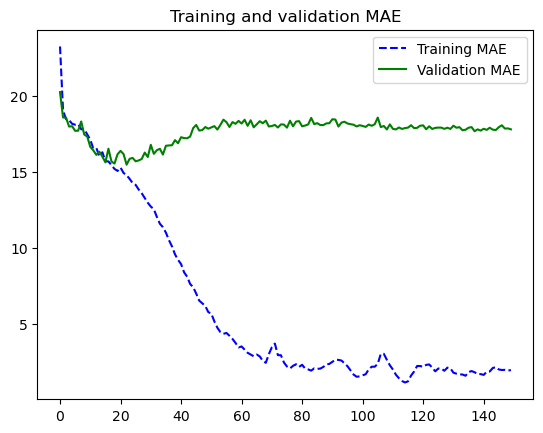

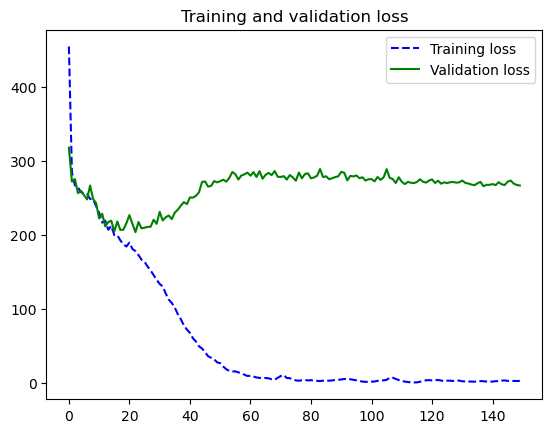

---
Training PCK@0.5 = 0.835004483573816
Validation PCK@0.5 = 0.1855166802278275
Test PCK@0.5 = 0.15177865612648223
---


In [26]:
plot_training_analysis(history)

# Calcul du PCK
print('---')   
y_pred = model.predict(x_train)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_pred = model.predict(x_val)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_pred = model.predict(x_test)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))
print('---')

Le PCK est maintenant à 0.9 ce qui commence à être très satisfaisant ur l'ensemble d'apprentissage. On peut donc maintenant s'attaquer au sur-apprentissage. 

## Correction du sur-apprentissage par **régularisation**

In [28]:
from tensorflow.keras import regularizers

# Chargement des données : 1000 images d'apprentissage, 100 de validation, 100 de test    
x, y = load_data(image_size=64, num_images=1200)  
x = x/255
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/6, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

print(x_train.shape, x_val.shape, x_test.shape)

# On repart de modèle simple, mais on ajoute de la REGULARISATION dans la première couche du MLP
model = models.Sequential()

model.add(Conv2D(32,(3,3), padding='same', input_shape=(64,64,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(96,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu', kernel_regularizer=regularizers.l1(1e-2)))  # Régularisation L1
model.add(Dense(28,activation='linear'))
model.add(Reshape((2,14)))


# On utilise Adam, et on va minimiser la MSE
# On affiche également la métrique MAE, qui nous permettra d'avoir une valeur plus interprétable
opt = optimizers.Adam(learning_rate=3e-4) 


model.compile(loss=custom_mse,
              optimizer=opt,
              metrics=custom_mae)

history = model.fit(x_train, y_train,
          epochs=150,
          validation_data = (x_val, y_val), 
          batch_size=10)

(1000, 64, 64, 3) (100, 64, 64, 3) (100, 64, 64, 3)
Epoch 1/150
100/100 [==============================] - 7s 57ms/step - loss: 746.5117 - custom_mae: 26.1814 - val_loss: 419.6586 - val_custom_mae: 19.5098
Epoch 2/150
100/100 [==============================] - 7s 72ms/step - loss: 383.2601 - custom_mae: 18.9548 - val_loss: 379.9777 - val_custom_mae: 18.9620
Epoch 3/150
100/100 [==============================] - 7s 71ms/step - loss: 352.9730 - custom_mae: 18.5524 - val_loss: 351.9170 - val_custom_mae: 18.7138
Epoch 4/150
100/100 [==============================] - 6s 65ms/step - loss: 339.3700 - custom_mae: 18.4440 - val_loss: 331.5023 - val_custom_mae: 18.2197
Epoch 5/150
100/100 [==============================] - 5s 54ms/step - loss: 330.5387 - custom_mae: 18.3227 - val_loss: 324.3508 - val_custom_mae: 18.2865
Epoch 6/150
100/100 [==============================] - 8s 80ms/step - loss: 315.5188 - custom_mae: 18.0094 - val_loss: 327.8918 - val_custom_mae: 18.3065
Epoch 7/150
100/100 [===

In [ ]:
plot_training_analysis(history)

# Calcul du PCK
print('---')   
y_pred = model.predict(x_train)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_pred = model.predict(x_val)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_pred = model.predict(x_test)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))
print('---')

Même en testant des valeurs très hautes de régularisation, on ne parvient pas réellement à limiter le surapprentissage. Je pense qu'il est dû à la nature du problème, ou plutôt à la mauvaise formulation du problème. En effet, sur les images de la base de données, on a en fait deux types de problème : 1) localiser la personne sur l'image, et 2) localiser les joints sur la personne.
Dans l'article de [Toshev et al.], les auteurs travaillent sur des imagettes extraites des images initiales, qui contiennent uniquement l'humain considéré. On doit "juste" localiser les joints. Cela permet également une distribution des sorties plus favorable pour l'apprentissage.
Je pense que ce double-problème de localisation et de régression rend l'architecture du réseau que l'on a fabriqué peu adaptée au problème ; il faudrait envisager d'autres architectures (plus profondes ?) pour éventuellement arriver à obtenir des résultats.

Je n'ai pas voulu modifier le problème comme Toshev et al. (traiter des imagettes qui ne contiennent que des personnes) car au TP suivant, on verra que même sans ça on peut obtenir des résultats en formulant mieux le problème. 

## Test sur toute la base de données (9000 images)

Malgré le fait que ce réseau ne soit pas pleinement satisfaisant (cf commentaires ci-dessus), on décide de le tester quand même toute la base de données (9000 images d'entraînement, 500 de validation et 500 de test) pour voir si le sur-apprentissage est un peu limité...

_**Remarque** : Assurez-vous d'avoir une bonne machine, un GPU et d'être patient..._

In [ ]:
# Chargement des données : 9000 images d'apprentissage, 500 de validation, 500 de test    
x, y = load_data(image_size=64, num_images=10000)  
x = x/255
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/10, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

print(x_train.shape, x_val.shape, x_test.shape)


# On utilise le modèle "augmenté" défini § 4.3.2
model = models.Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(64,64,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(384,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(28,activation='linear'))
model.add(Reshape((2,14)))


# On utilise Adam, et on va minimiser la MSE
# On affiche également la métrique MAE, qui nous permettra d'avoir une valeur plus interprétable
opt = optimizers.Adam(learning_rate=3e-4) 


model.compile(loss=custom_mse,
              optimizer=opt,
              metrics=custom_mae)

history = model.fit(x_train, y_train,
          epochs=150,
          validation_data = (x_val, y_val), 
          batch_size=10)

In [ ]:
plot_training_analysis(history)

# Calcul du PCK
print('---')   
y_pred = model.predict(x_train)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_pred = model.predict(x_val)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_pred = model.predict(x_test)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))
print('---')

Le sur-apprentissage est toujours là, même si on observe quand même une amélioration des performances (PCK ~ 0.2 et val_mae ~13.7)

## ON AURAIT PU L'ABORDER : Augmentation de données


<span style="color:purple">**Je _[Axel Carlier, ndlr]_ avais proposé la partie ci-dessous pour limiter le sur-apprentissage mais en réalité on y arrive pas non plus. L'augmentation est en plus imparfaite car on perd l'information de visibilité des joints et on n'a pas pris le temps d'implanter une version qui permet de l'inférer (par exemple, en post-traitant les joints augmentés). Du coup je ne l'ai pas inclus dans le TP ! Mais vous pouvez regarder si ça vous amuse !**</span> 

Pour augmenter les données, il va falloir s'y prendre un peu différemment que pour la classification d'image. En effet contrairement à la classification, une modification de l'image va également altérer son label associé. Par exemple, si l'on applique une translation à l'image de 2 pixels vers la droite, alors la position des joints associés à l'image doit également être translatée.

Pour réaliser cette opération, on va devoir modifier notre code d'entraînement pour gagner un peu plus de contrôle sur la création des mini-batches de données. L'idée est que lorsqu'un mini-batch de données est sélectionné, nous allons nous même appliquer l'augmentation aux images, et appliquer cette augmentation aux joints.

Pour cela, nous allons utiliser la classe **Sequence** de Keras et la librairie d'augmentation de données **Albumentation.ai** qui gère automatiquement la transformation des joint associée à celle des images.

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

In [ ]:
import albumentations as A
A.__version__
# Définition des tranformations que l'on veut appliquer à nos images :
transform = A.Compose([
        A.ShiftScaleRotate(p=1), # Translation, Rotation, et mise à l'échelle
        A.OneOf([
            A.HueSaturationValue(p=0.5), 
            A.RGBShift(p=0.7)
        ], p=1),                          
        A.RandomBrightnessContrast(p=0.5)
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)) # Il ne faut pas enlever les joints qui deviennent invisibles !

In [ ]:
from tensorflow.python.keras.utils.data_utils import Sequence

class LSPDSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices = np.arange(self.x.shape[0])
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def apply_augmentation(self, bx, by):
        # On enlève les valeurs négatives de y car cela perturbe l'augmentation
        visibilities = by[:,2,:]
        positions = by[:,0:2,:]
        positions = np.where(positions > 0, positions, 0.0)
        
        bx_t = np.zeros(bx.shape)
        by_t = np.zeros(by.shape)
        
        for i in range(bx_t.shape[0]):
            # Application de l'augmentation de données image par image
            transformed = self.augment(image=(bx[i]*255).astype('uint8'), keypoints=np.transpose(positions[i]))
            bx_t[i] = transformed['image']
            by_t[i,0:2,:] = np.transpose(transformed['keypoints'])
          
        by_t[:,2,:]= visibilities
        return bx_t, by_t
        
    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        
        # Application de l'augmentation de données
        transformed_batch_x, transformed_batch_y = self.apply_augmentation(batch_x, batch_y)
        
        return (transformed_batch_x/255).astype('float32'), transformed_batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [ ]:
# Chargement de 2 images
x, y = load_data(image_size=64, num_images=2)       
x = x/255

print('Données non augmentées')
print_data(x*255, y, 0)
print_data(x*255, y, 1)

# On instancie notre séquence avec les deux premières images de l'ensemble d'apprentissage, et une taille de batch de 2
lspd_seq = LSPDSequence(x, y, 2, transform)
# On récupère notre premier batch (en fait, le seul)
bx, by = lspd_seq.__getitem__(0)

print('Données augmentées')
# On affiche les images transformées pour visualiser l'effet de l'augmentation 
print_data(bx*255,by,0)
print_data(bx*255,by,1)

On peut maintenant ré-entraîner notre réseau, mais sur les images augmentées !

In [ ]:
from sklearn.model_selection import train_test_split
import keras
from keras.layers import *
from keras import models

# Chargement des données : 1000 images d'apprentissage, 100 de validation, 100 de test    
x, y = load_data(image_size=64, num_images=10000)  
x = x/255
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/10, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

print(x_train.shape, x_val.shape, x_test.shape)

# Définition d'un modèle simple, type "LeNet"
model = models.Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(64,64,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(28,activation='linear'))
model.add(Reshape((2,14)))

# On utilise Adam, un optimiseur simple, et on va minimiser la MSE
# On affiche également la métrique MAE, qui nous permettra d'avoir une valeur plus interprétable
opt = keras.optimizers.Adam(learning_rate=3e-4) 


model.compile(loss=custom_mse,
              optimizer=opt,
              metrics=custom_mae)

# Instanciation de notre Sequence :
lspd_seq = LSPDSequence(x_train, y_train, 32, transform)


history = model.fit(lspd_seq,
          epochs=500,
          validation_data = (x_val, y_val), 
          batch_size=32)

plot_training_analysis(history)

# Calcul du PCK
y_pred = model.predict(x_train)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_pred = model.predict(x_val)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_pred = model.predict(x_test)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))

L'apprentissage est considérablement ralenti ! Le réseau apprend bien, mais beaucoup plus lentement, du fait de la plus grande diversité des images qui lui sont fournies en entrée. Malheureusement, malgré cette diversité, le sur-apprentissage est un peu plus diminué mais reste très élevé. J'ai arrêté l'entrainement en cours car on voit que le sur-apprentissage est toujours là. 

La vraie bonne solution est d'adopter une approche plus adaptée à la résolution du problème. $\implies$ **_cf._ PARTIE II**